In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import sys
import matplotlib.pyplot as plt
import gc
import anndata
import glob
from multiprocessing import Pool
import os
from sklearn import metrics


# AIFI Labels

In [2]:
files_list = glob.glob(os.path.join('/home/jupyter/Maxim_dataset_followup/Labels_AIFI/', 
                                    "*L1_predicted_labels.csv"))
AIFI_L1 = pd.concat((pd.read_csv(f) for f in files_list), ignore_index=True)

files_list = glob.glob(os.path.join('/home/jupyter/Maxim_dataset_followup/Labels_AIFI/', 
                                    "*L2_predicted_labels.csv"))
AIFI_L2 = pd.concat((pd.read_csv(f) for f in files_list), ignore_index=True)

files_list = glob.glob(os.path.join('/home/jupyter/Maxim_dataset_followup/Labels_AIFI/', 
                                    "*L3_predicted_labels.csv"))
AIFI_L3 = pd.concat((pd.read_csv(f) for f in files_list), ignore_index=True)

# Original Labels

In [3]:
Origional_Labels_L1=pd.read_csv('/home/jupyter/Maxim_dataset_followup/GEX_HTO_processed/all_pbmcs/all_pbmcs_metadata.csv')
Origional_Labels_L1=Origional_Labels_L1[["Unnamed: 0","Cluster_names"]]

In [4]:
files_list = glob.glob('/home/jupyter/Maxim_dataset_followup/GEX_HTO_processed/**/*meta*.csv', recursive=True)

In [5]:
files_list = [item for item in files_list if item != '/home/jupyter/Maxim_dataset_followup/GEX_HTO_processed/all_pbmcs/all_pbmcs_metadata.csv']
proj_meta=pd.read_csv(files_list[0])
proj_meta["Cluster_names"]='progenitor'
proj_meta.to_csv(files_list[0])

In [6]:
Origional_Labels_L2 = pd.concat(
    (pd.read_csv(f).assign(filename=os.path.splitext(os.path.basename(f))[0]) for f in files_list),
    ignore_index=True
)


In [7]:
Origional_Labels_L2['filename'] = Origional_Labels_L2['filename'].str.replace("_metadata", "", regex=False)

In [8]:
Origional_Labels_L2['filename'] = Origional_Labels_L2['filename'].str.replace("_", " ", regex=False)

In [9]:
Origional_Labels_L2["Cluster_names"]= Origional_Labels_L2["Cluster_names"].astype(str)+" "+Origional_Labels_L2["filename"].astype(str)

In [10]:
Origional_Labels_L2=Origional_Labels_L2[["Unnamed: 0","Cluster_names"]]

# rename columns

In [11]:
overlapping_barcodes= set(AIFI_L3['index']) & set(Origional_Labels_L1["Unnamed: 0"]) & set(Origional_Labels_L2["Unnamed: 0"])

In [12]:
len(overlapping_barcodes)

1914877

In [13]:
AIFI_L1.index= AIFI_L1['index'].tolist()
AIFI_L2.index= AIFI_L2['index'].tolist()
AIFI_L3.index= AIFI_L3['index'].tolist()
AIFI_L1=AIFI_L1.loc[list(overlapping_barcodes)]
AIFI_L2=AIFI_L2.loc[list(overlapping_barcodes)]
AIFI_L3=AIFI_L3.loc[list(overlapping_barcodes)]


AIFI_L1=AIFI_L1[['predicted_labels']]
AIFI_L2=AIFI_L2[['predicted_labels']]
AIFI_L3=AIFI_L3[['predicted_labels']]
AIFI_L1.columns= ['AIFI_L1']
AIFI_L2.columns= ['AIFI_L2']
AIFI_L3.columns= ['AIFI_L3']

In [14]:
Origional_Labels_L1.index=Origional_Labels_L1["Unnamed: 0"].tolist()
Origional_Labels_L2.index=Origional_Labels_L2["Unnamed: 0"].tolist()
Origional_Labels_L1=Origional_Labels_L1.loc[list(overlapping_barcodes)]
Origional_Labels_L2=Origional_Labels_L2.loc[list(overlapping_barcodes)]

Origional_Labels_L1=Origional_Labels_L1[['Cluster_names']]
Origional_Labels_L2=Origional_Labels_L2[['Cluster_names']]
Origional_Labels_L1.columns= ['Origional_Labels_L1']
Origional_Labels_L2.columns= ['Origional_Labels_L2']

In [15]:
Origional_Labels_L2=Origional_Labels_L2[~Origional_Labels_L2.index.duplicated()]

# Compare

In [16]:
merged_df = pd.concat([AIFI_L1, AIFI_L2, AIFI_L3, Origional_Labels_L1, Origional_Labels_L2], axis=1)

### Confusion Matrix

In [17]:
def plot_error_matrix(cm, x_classes, y_classes, title='', figsize=[5,5],normalize=False, show_text=True):
    np.fill_diagonal(cm, 0)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.1%'
    else:
        fmt = 'd'
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()

    # Set tick marks for x and y axes separately
    x_tick_marks = np.arange(len(x_classes))
    y_tick_marks = np.arange(len(y_classes))
    plt.xticks(x_tick_marks, x_classes, rotation=90)
    plt.yticks(y_tick_marks, y_classes)

    if show_text:
        thresh = cm.max() / 2.
        for i, j in np.ndindex(cm.shape):
            if cm[i, j] > 0:  
                plt.text(j, i, format(cm[i, j], fmt),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

In [18]:
def plot_error_matrix_percentage(cm, x_classes, y_classes, title,label_fontsize=12, xlabel="Predicted Label", ylabel="True Label", figsize=[5,5],show_text=True):
    # Normalize the matrix to percentages
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=figsize)

    # Plot the matrix
    plt.imshow(cm_percentage, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)

    # Set tick marks for x and y axes
    x_tick_marks = np.arange(len(x_classes))
    y_tick_marks = np.arange(len(y_classes))
    plt.xticks(x_tick_marks, x_classes, rotation=90, fontsize=label_fontsize)
    plt.yticks(y_tick_marks, y_classes, fontsize=label_fontsize)
    # Add axis labels
    plt.xlabel(xlabel, fontsize=label_fontsize)
    plt.ylabel(ylabel, fontsize=label_fontsize)
    if show_text:
        thresh = cm_percentage.max() / 2.
        for i, j in np.ndindex(cm_percentage.shape):
            if cm_percentage[i, j] > 0:  # Only show non-zero values
                plt.text(j, i, f"{cm_percentage[i, j]:.1f}%",
                         horizontalalignment="center",
                         color="white" if cm_percentage[i, j] > thresh else "black")

    plt.tight_layout()

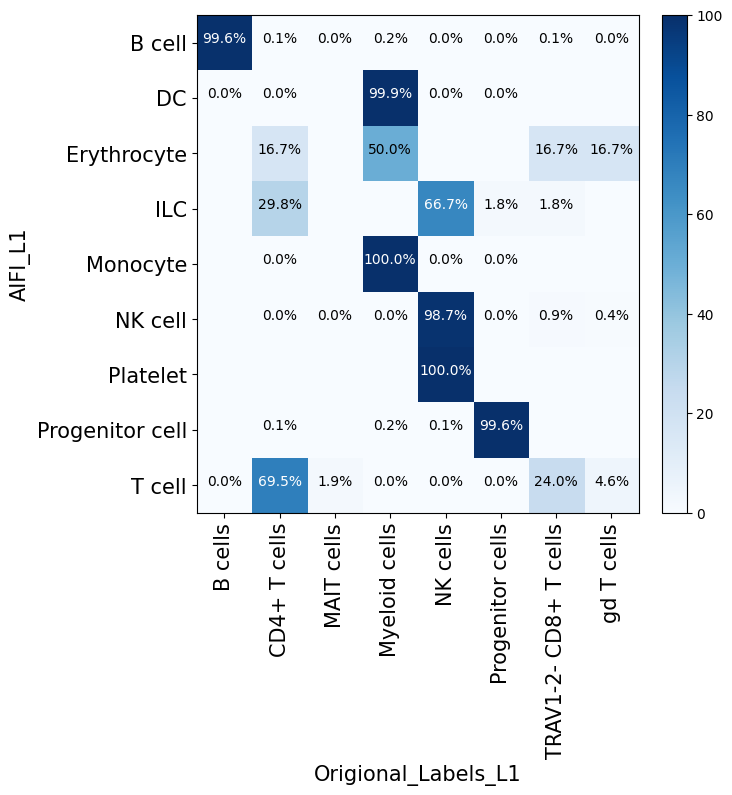

In [19]:
distribution_matrix = pd.crosstab(merged_df['AIFI_L1'], merged_df['Origional_Labels_L1'])

cm = distribution_matrix.values
plot_error_matrix_percentage(cm, figsize=[8,8],label_fontsize=15,
                  x_classes=distribution_matrix.columns, 
                  y_classes=distribution_matrix.index, 
                             xlabel="Origional_Labels_L1", 
                             ylabel="AIFI_L1",
                  title="")

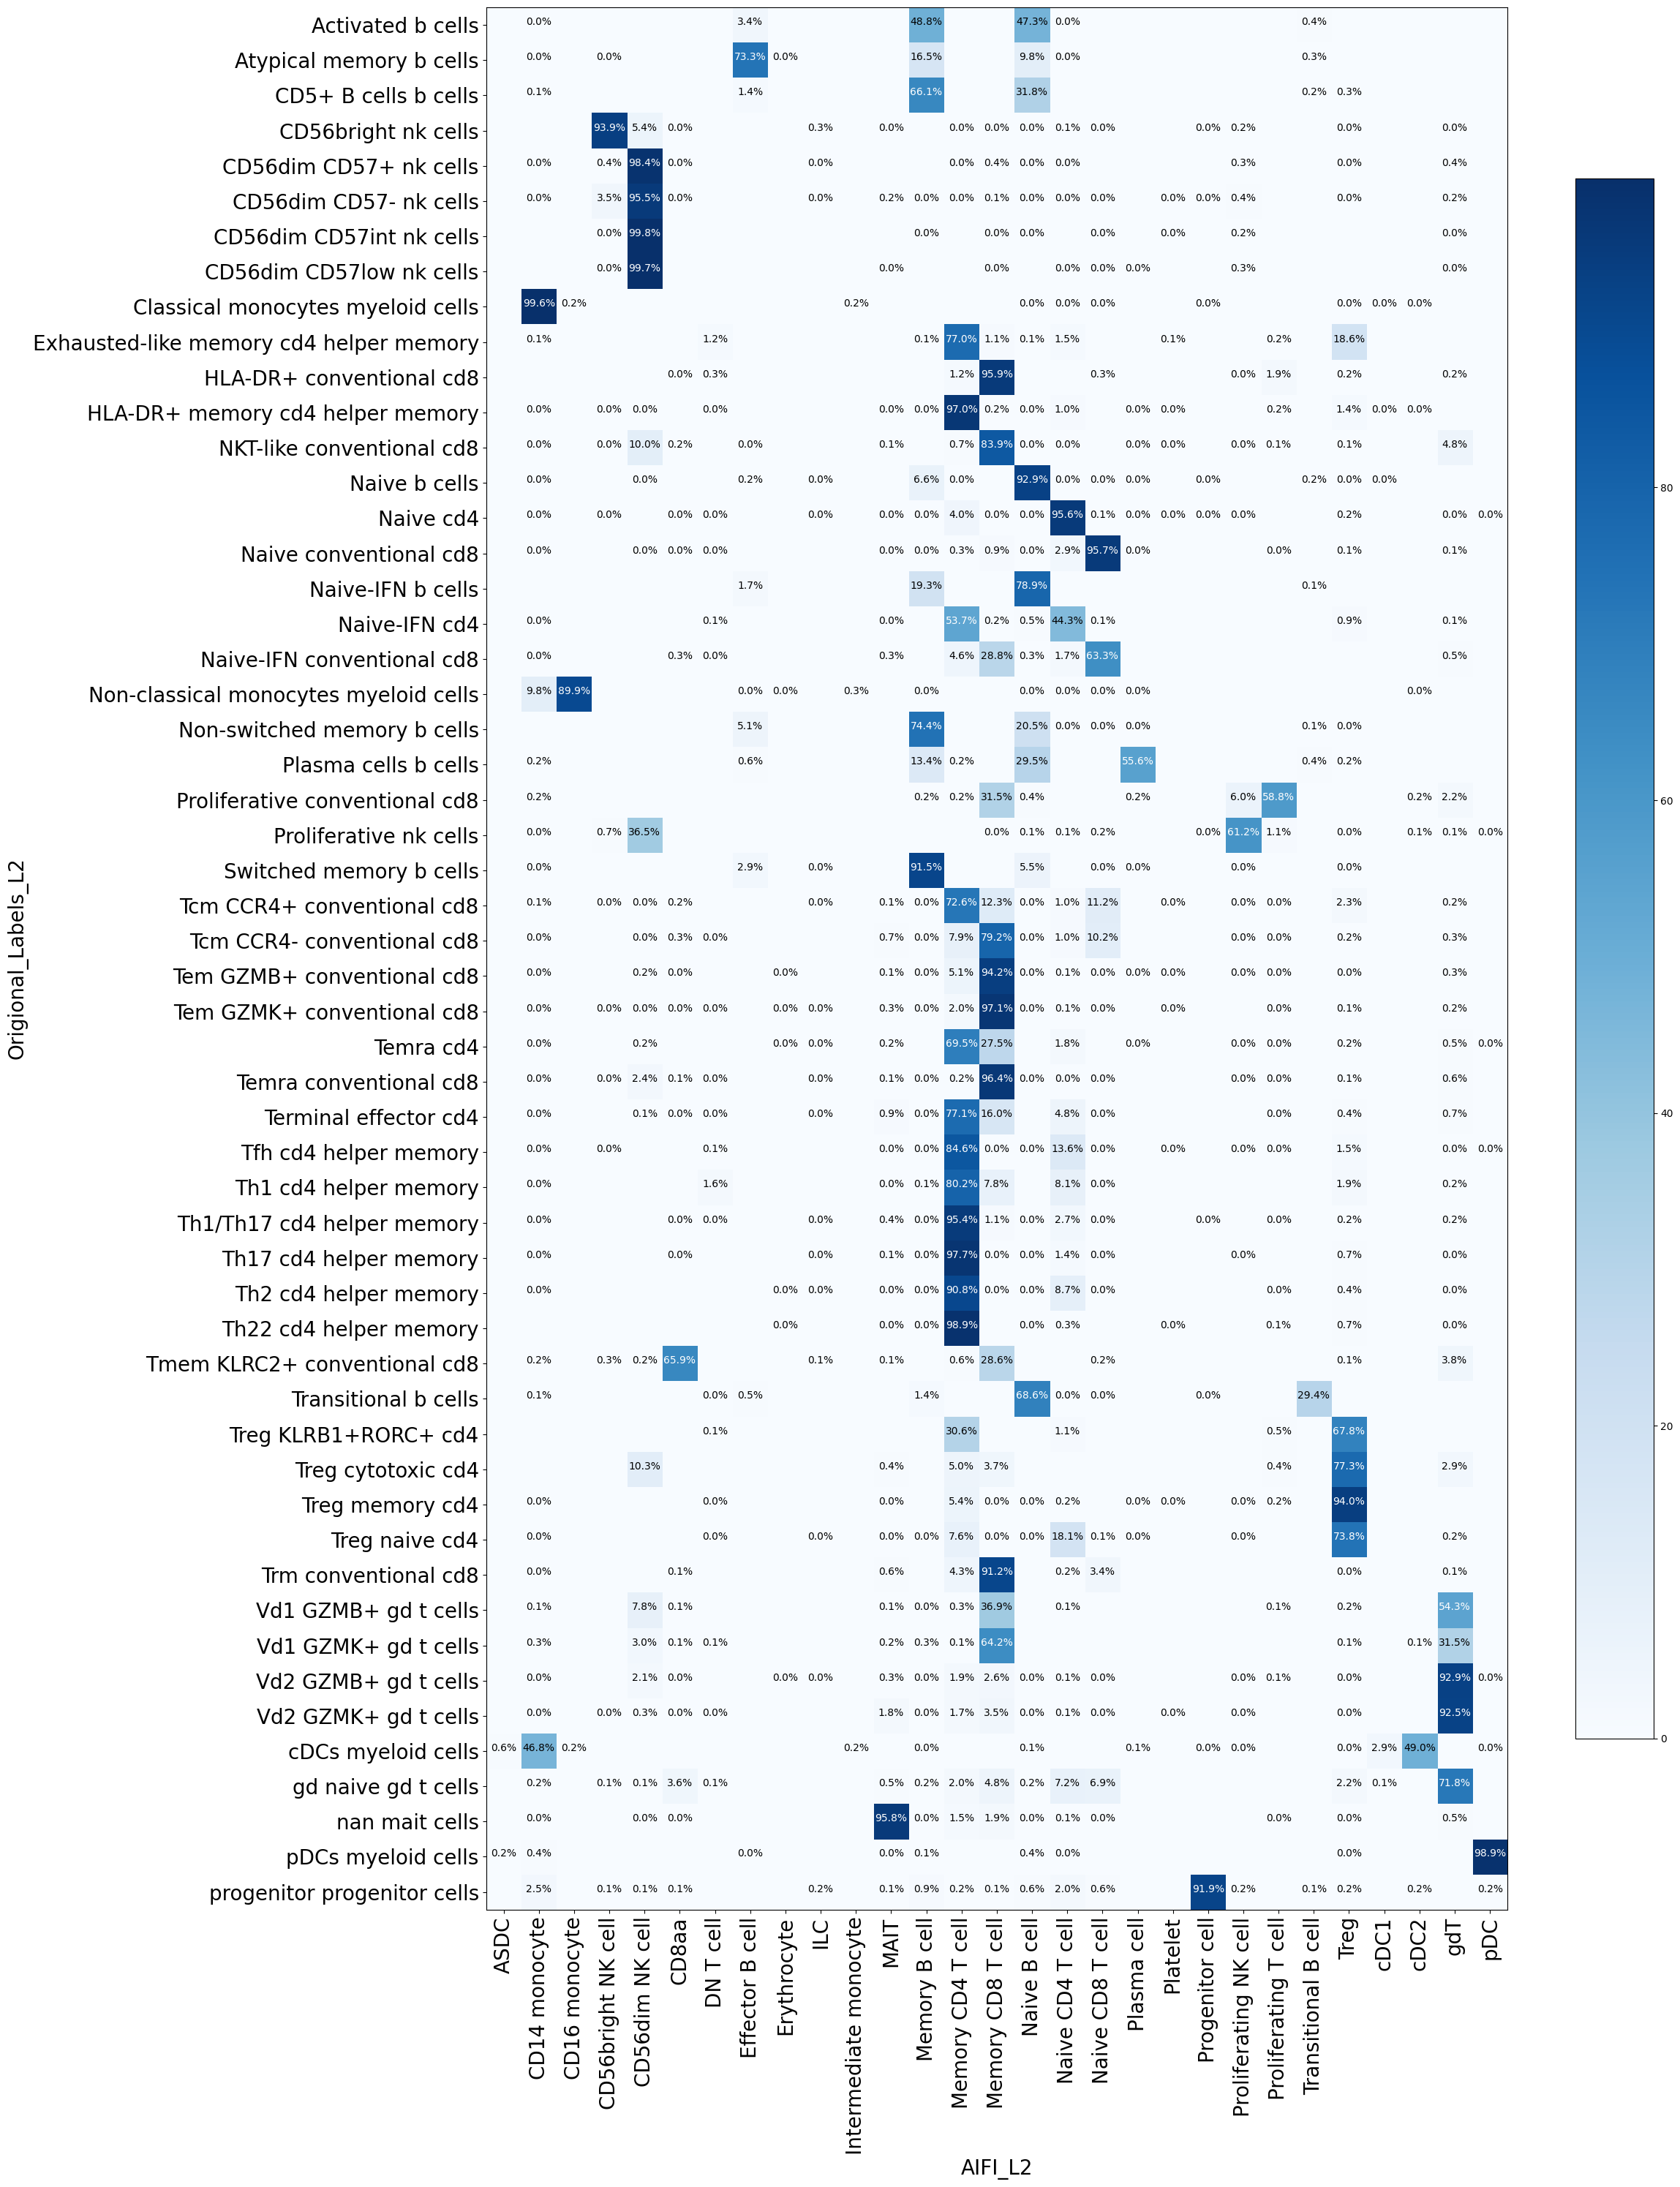

In [20]:

distribution_matrix = pd.crosstab(merged_df['Origional_Labels_L2'], merged_df['AIFI_L2'])

cm = distribution_matrix.values
plot_error_matrix_percentage(cm, figsize=[25,30],label_fontsize=20,
                  x_classes=distribution_matrix.columns, 
                  y_classes=distribution_matrix.index, 
                             xlabel="AIFI_L2", 
                             ylabel="Origional_Labels_L2",
                  title="")

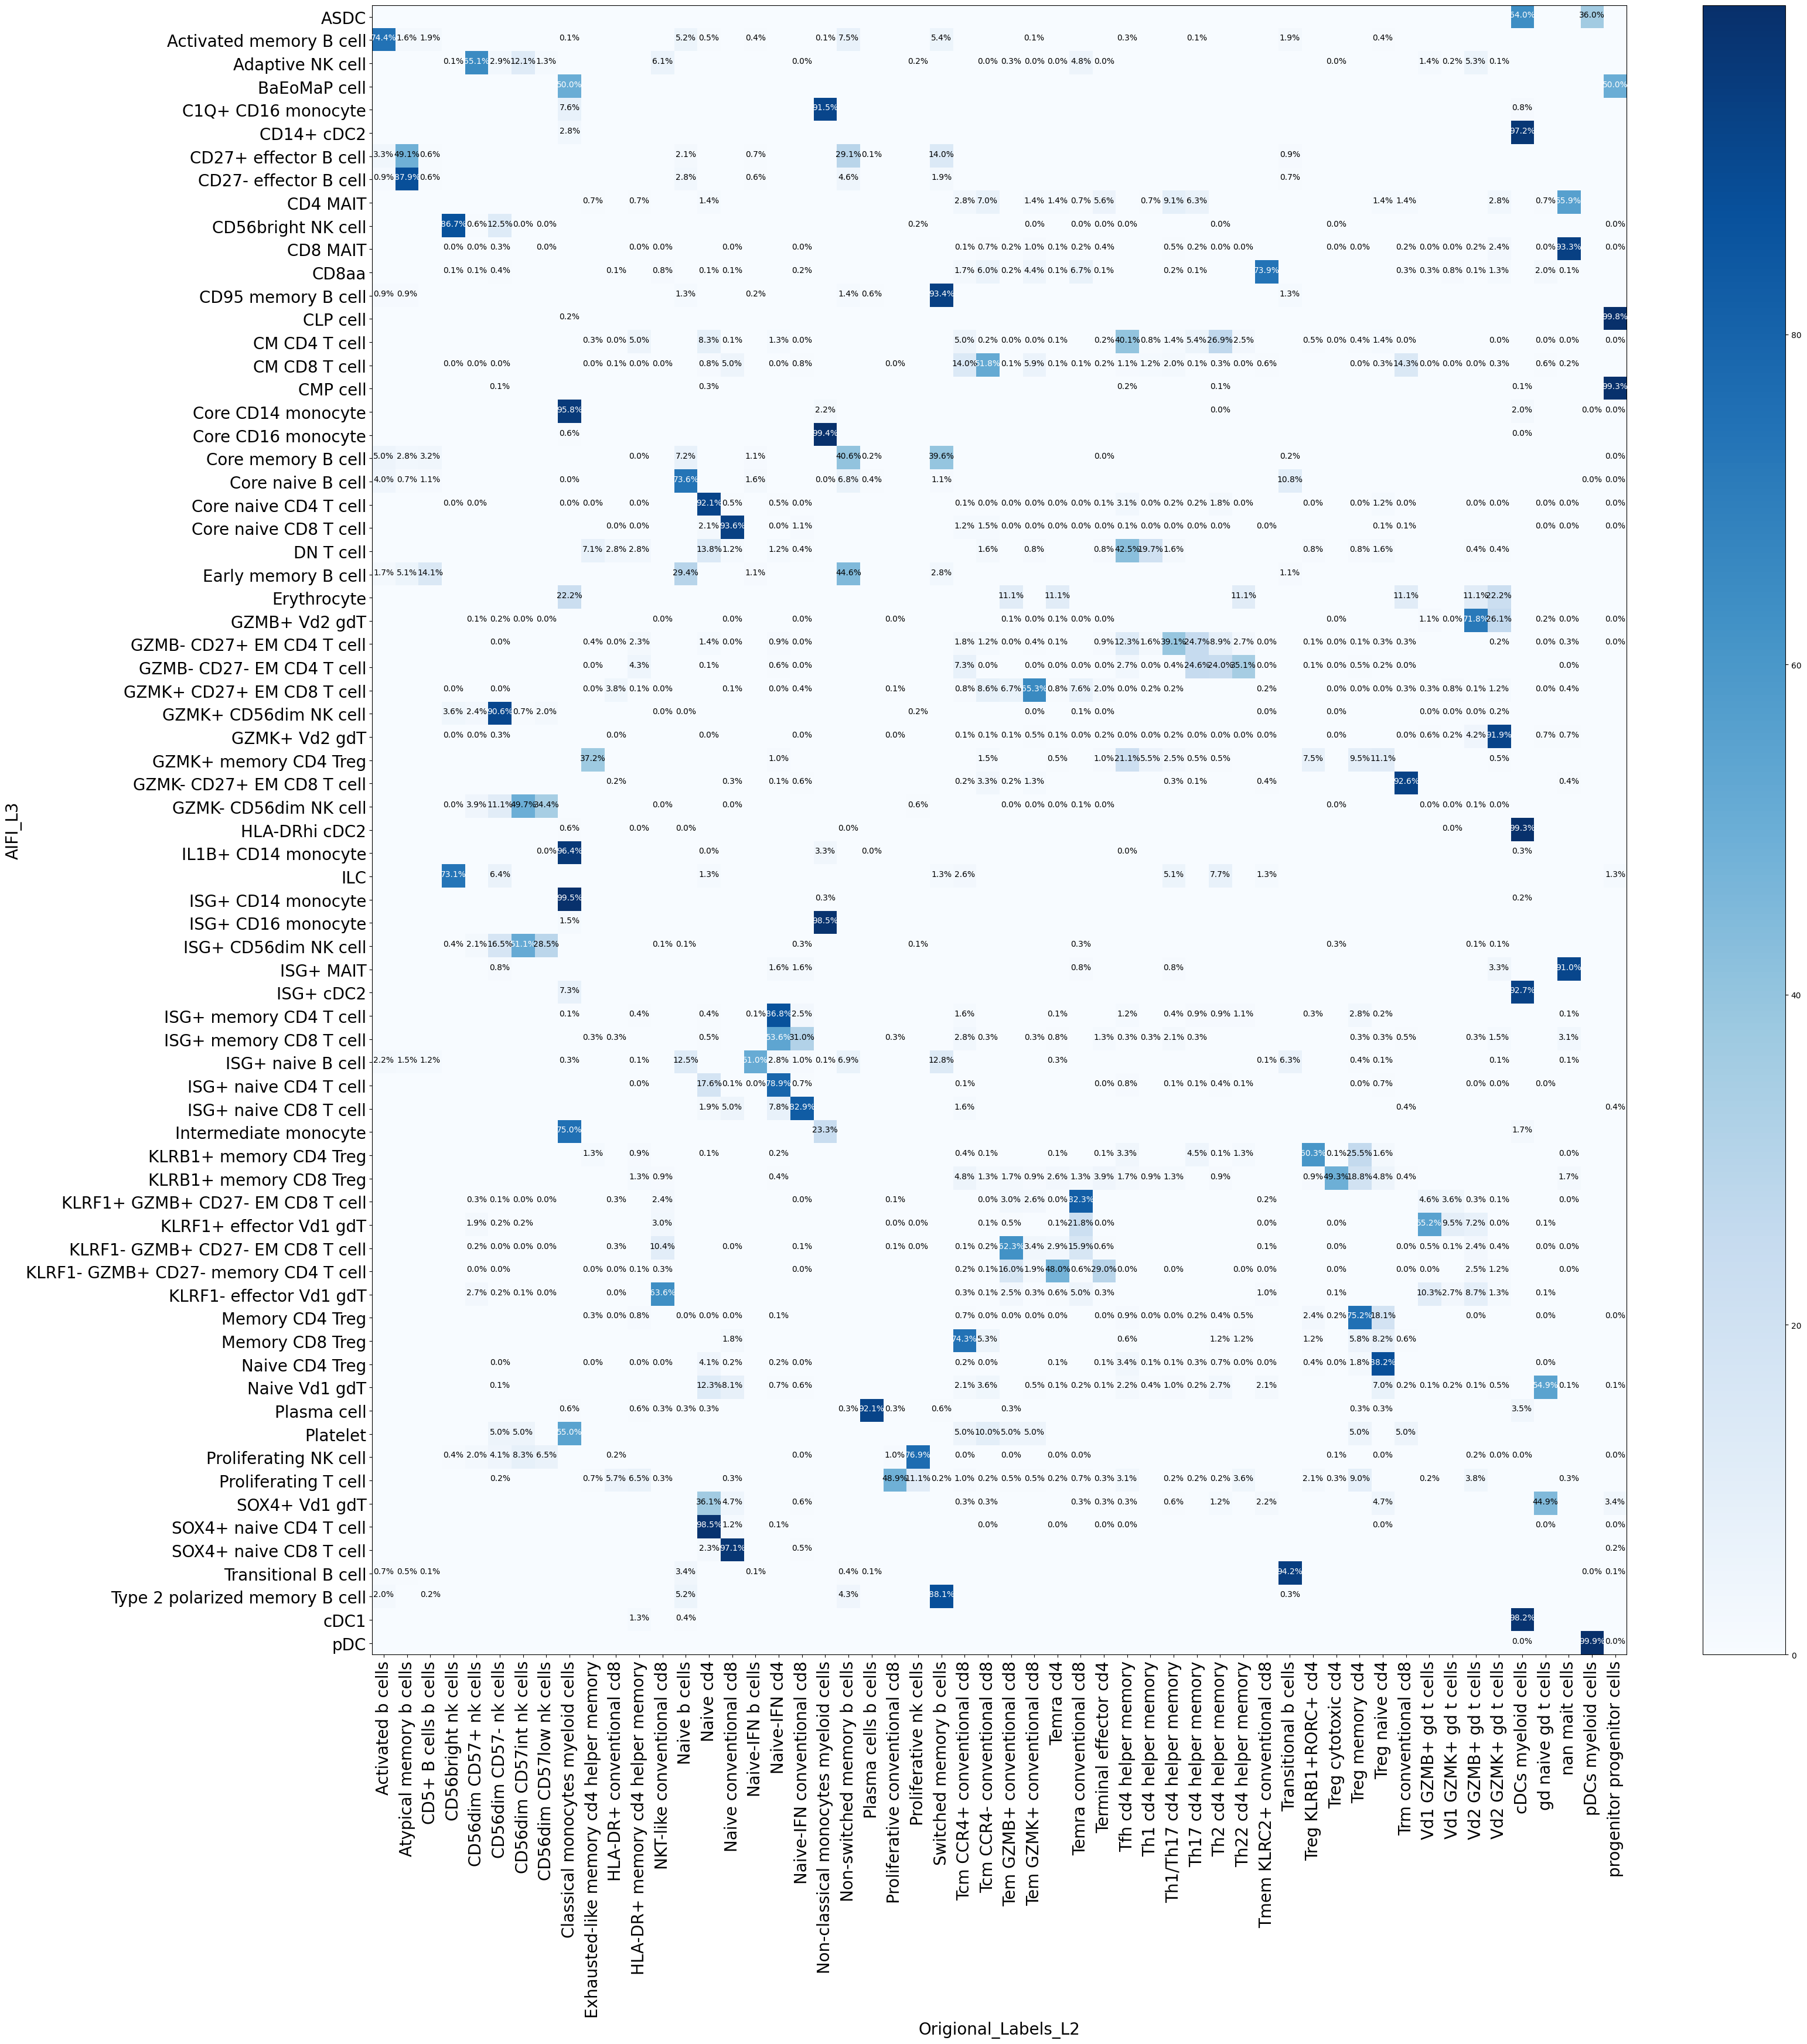

In [21]:

distribution_matrix = pd.crosstab(merged_df['AIFI_L3'], merged_df['Origional_Labels_L2'])

cm = distribution_matrix.values
plot_error_matrix_percentage(cm, figsize=[35,35],label_fontsize=20,
                  x_classes=distribution_matrix.columns, 
                  y_classes=distribution_matrix.index, 
                             xlabel="Origional_Labels_L2", 
                             ylabel="AIFI_L3",
                  title="")

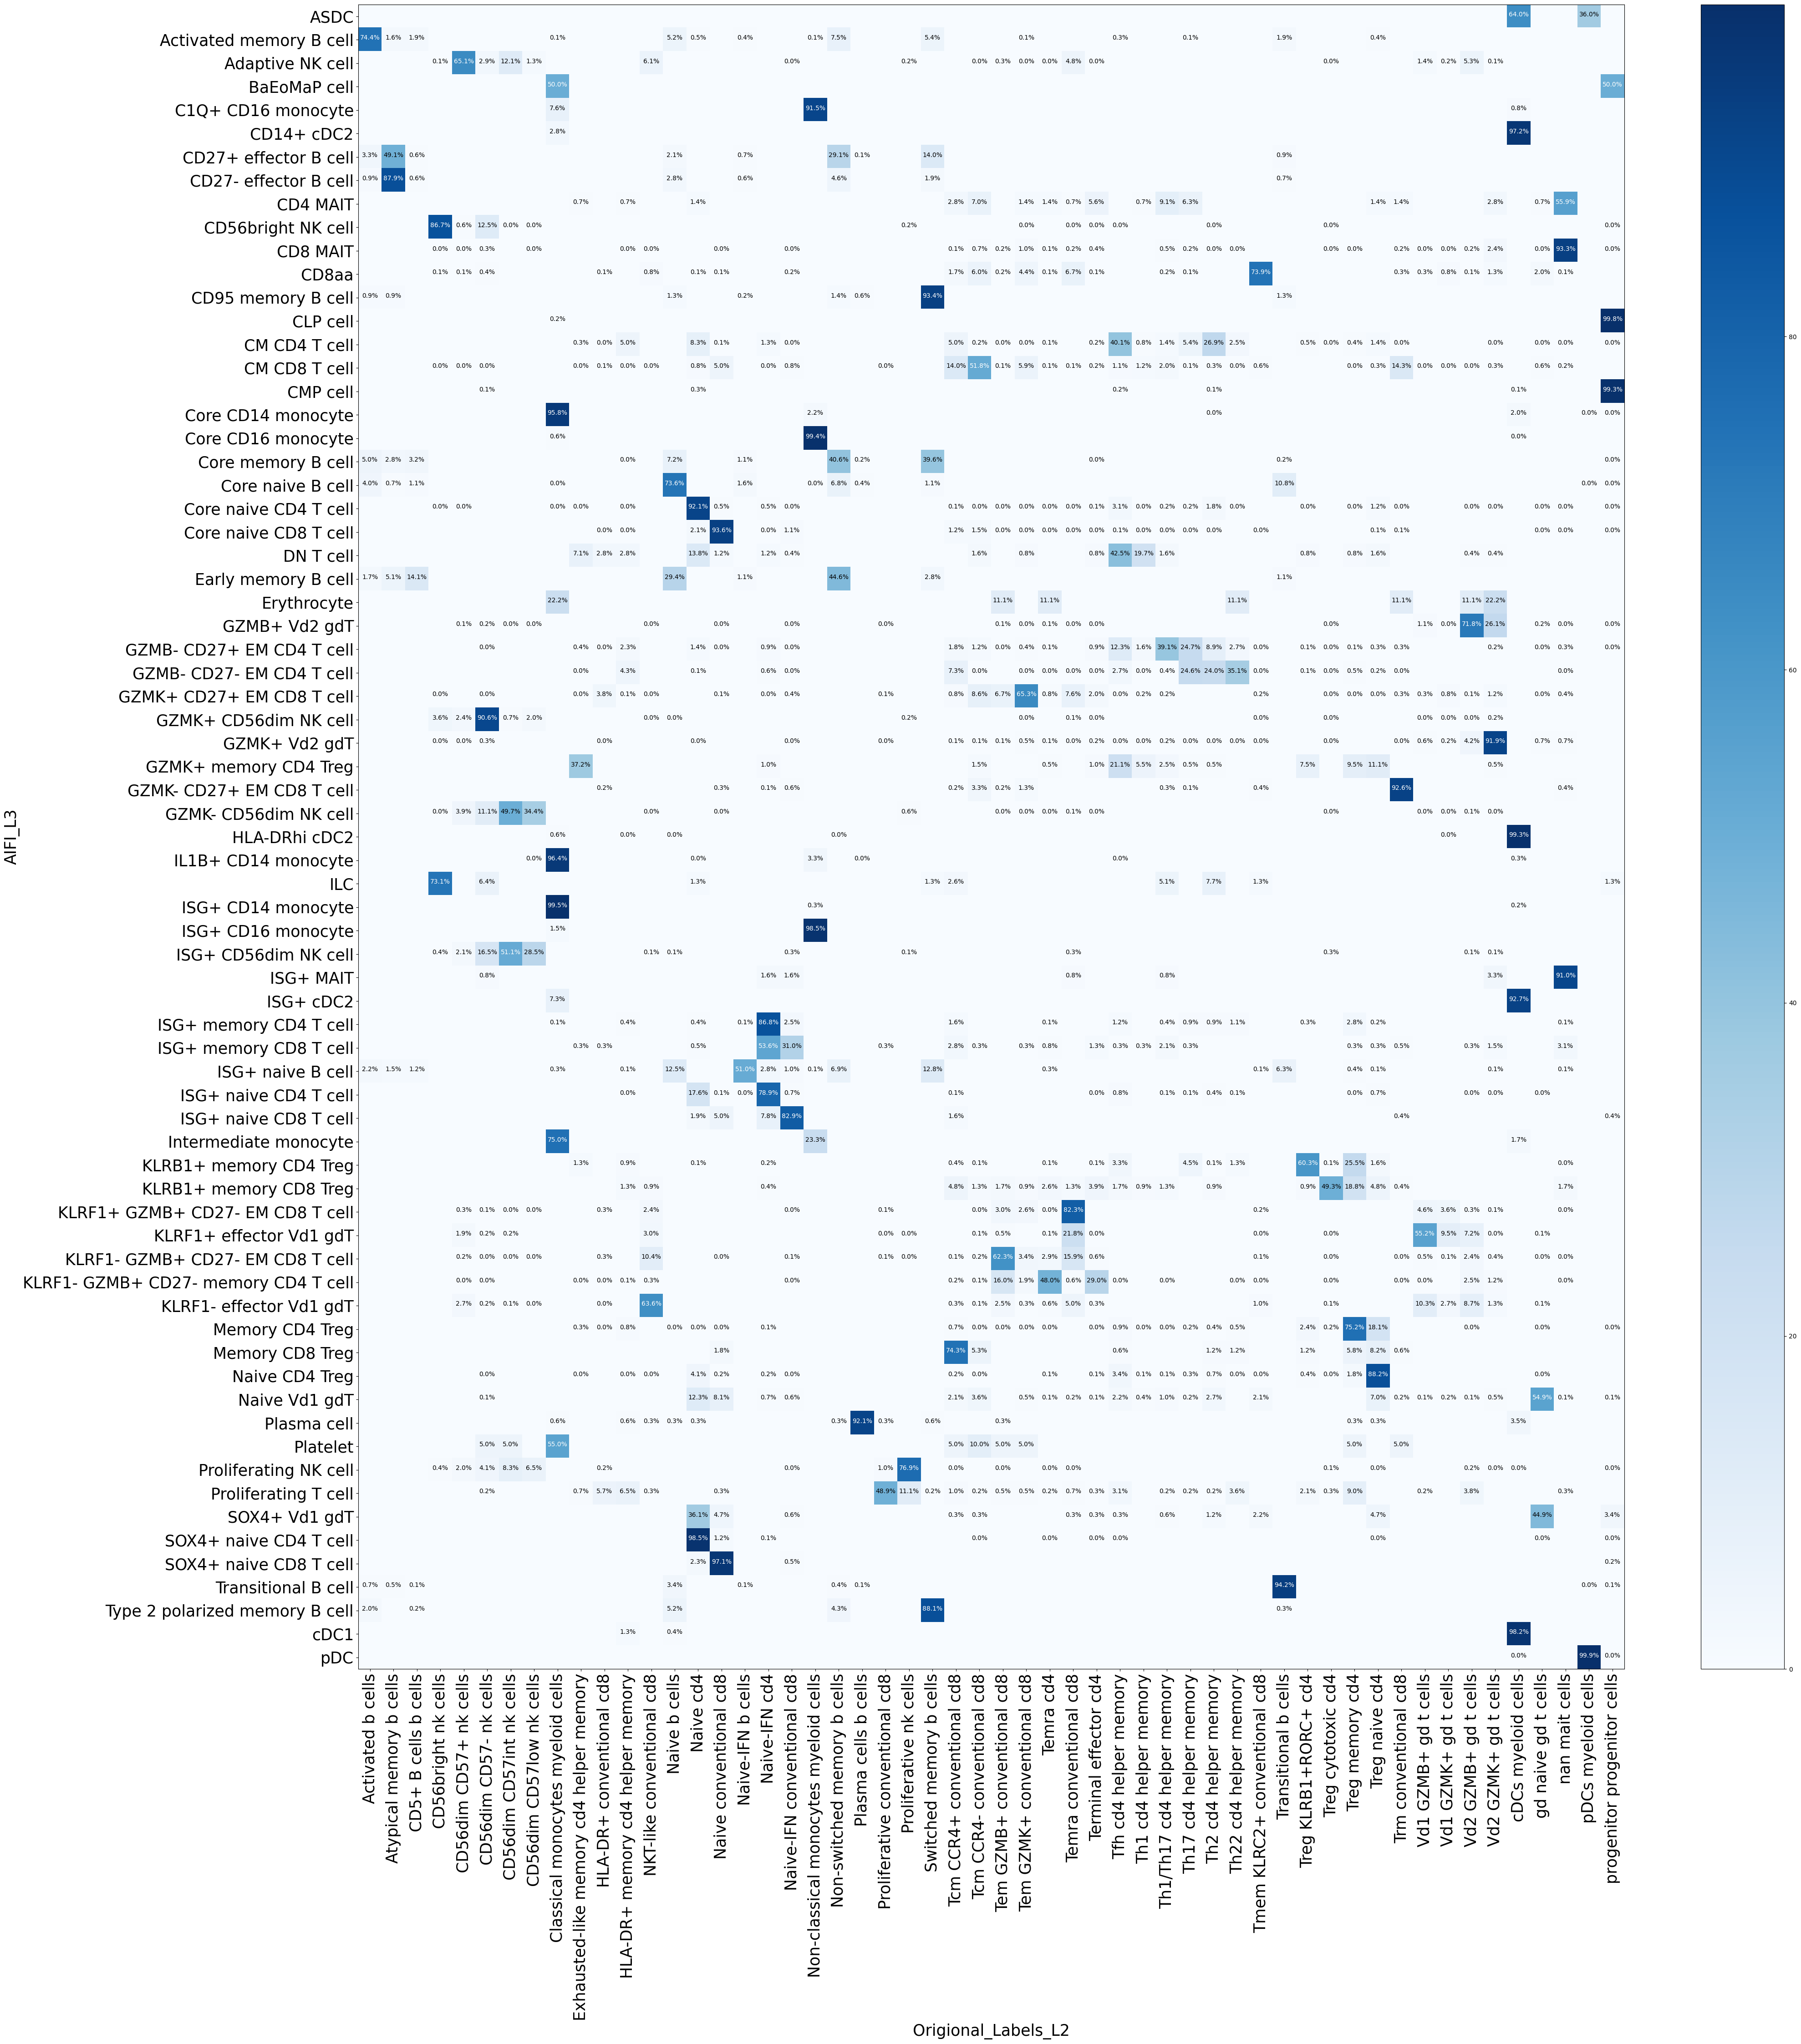

In [27]:
distribution_matrix = pd.crosstab(merged_df['AIFI_L3'], merged_df['Origional_Labels_L2'])

cm = distribution_matrix.values
plot_error_matrix_percentage(cm, figsize=[45,45],label_fontsize=25,
                  x_classes=distribution_matrix.columns, 
                  y_classes=distribution_matrix.index, 
                             xlabel="Origional_Labels_L2", 
                             ylabel="AIFI_L3",
                  title="")

In [23]:
merged_df.to_csv("labels.csv")